In [1]:
import quinn
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()


22/07/07 09:27:54 WARN Utils: Your hostname, fossa-dsa-001 resolves to a loopback address: 127.0.1.1; using 192.168.0.111 instead (on interface wlp3s0)
22/07/07 09:27:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/07 09:27:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/07/07 09:27:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:

dataset_df = spark.read.csv('Monkey_Pox_Cases_Worldwide.csv', header=True)
daily_df = spark.read.csv(
    'Daily_Country_Wise_Confirmed_Cases.csv', header=True)

total_df = dataset_df.select(
    dataset_df['Country'], dataset_df['Confirmed_Cases'])

dataset_df = total_df.join(daily_df, ['Country'], how='left')


def dashes_to_underscores(s):
    return s.replace("-", "_")


dataset_df = dataset_df.transform(
    quinn.with_columns_renamed(dashes_to_underscores))

# dataset_df.write.option('header', True) \
                # .csv('../data/daily_cases.csv')


In [3]:
import pandas as pd
import numpy as np

# turn the spark df into pandas df
pd_pox = dataset_df.toPandas()

# drop the silly enumerated index and replace it with count=rty names
pd_pox.set_index('Country', drop=True, inplace=True)
# this will take our row and column indices and flip 'em
flipped_df = pd_pox.transpose()


# set df data types to floats and then into ints
flipped_df = flipped_df.astype(float).astype('Int64')
# see if we have any null values

# replace them with 0
flipped_df = flipped_df.fillna(0)

# pd.isnull(flipped_df).sum()

flipped_df.columns


22/07/07 09:28:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Index(['England', 'Portugal', 'Spain', 'United States', 'Canada', 'Sweden',
       'Italy', 'France', 'Belgium', 'Australia', 'Germany', 'Netherlands',
       'Israel', 'Switzerland', 'Greece', 'Austria', 'Argentina', 'Denmark',
       'Morocco', 'Slovenia', 'Scotland', 'Czech Republic',
       'United Arab Emirates', 'Finland', 'Wales', 'Northern Ireland', 'Sudan',
       'Bolivia', 'Iran', 'Ecuador', 'Malta', 'Ireland', 'Mexico', 'Pakistan',
       'French Guiana', 'Thailand', 'Peru', 'Brazil', 'Malaysia', 'Hungary',
       'Norway', 'Paraguay', 'Costa Rica', 'Gibraltar', 'Mauritius', 'Haiti',
       'Uruguay', 'Latvia', 'Cayman Islands', 'Kosovo', 'Turkey', 'Bahamas',
       'Ghana', 'India', 'Iceland', 'Poland', 'Bangladesh', 'Uganda',
       'Cambodia', 'Malawi', 'Venezuela', 'Romania', 'Georgia', 'Slovakia',
       'Luxembourg', 'Nepal', 'Chile', 'Serbia', 'Lebanon', 'South Korea',
       'Singapore', 'South Africa', 'Taiwan', 'Colombia', 'Croatia',
       'Bulgaria', 'Somalia', 

In [4]:
import pandas as pd

# turn the spark df into pandas df
pd_pox = dataset_df.toPandas()
# type(pd_pox)

# pd_pox.set_index('Country', drop = True, inplace = True)
country_cases = pd_pox.pivot_table(columns = 'Country', values = 'Confirmed_Cases', fill_value = 0)
# pd_pox.info()
# pd_pox.describe
country_cases

# pd.isnull(country_cases)
# pd_pox.index




Country,Argentina,Australia,Austria,Bahamas,Bangladesh,Belgium,Benin,Bolivia,Brazil,Bulgaria,...,Taiwan,Thailand,Turkey,Uganda,United Arab Emirates,United States,Uruguay,Venezuela,Wales,Zambia
Confirmed_Cases,6,12,37,0,0,168,3,0,79,3,...,1,0,1,0,13,559,0,1,15,0


In [2]:
# new_df = what.select_dtypes(include=[np.number])


total_cases = pd_pox.pivot_table(
    columns='Country', values='Confirmed_Cases', fill_value=0)





NameError: name 'pd_pox' is not defined

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

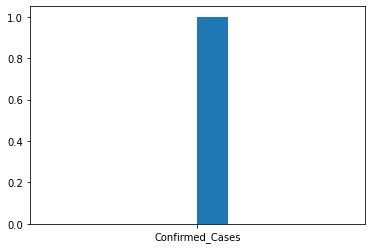

In [10]:
import matplotlib.pyplot as plt

# new_df = what.select_dtypes(include=[np.number])
# total_cases.describe
# total_cases.index

plt.hist(country_cases.index)
# # plt.xLabel('Country')
# # plt.yLabel('Confirmed_Cases')
# # plt.title('yikes')
# plt.show()


In [27]:
from pyspark.sql import SparkSession

from google.cloud import bigquery


os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/fossa/data/dont_worry_about_it/dearHenry.json"

client = bigquery.Client()
# dataset_id = f"{client.project}.monkeypox"
# bucket = 'hole-in-the'
# spark.conf.set('temporaryGcsBucket', bucket)

# dataset_df.write.format("bigquery") \
#     .mode("overwrite") \
#     .option("temporaryGcsBucket", "databricks-bigquery-temp") \
#     .option("table", "dearliza.monkeypox_data.monkeypox") \
#     .save()

dataset_df.write \
    .format("bigquery") \
    .option("temporaryGcsBucket", "hole-in-the") \
    .option("table", "monkeypox.monkeypox_table")





In [25]:
# Imports the Google Cloud client library
import os
from google.cloud import storage

# Instantiates a client

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/fossa/data/dont_worry_about_it/dearHenry.json"
client = storage.Client()


# Retrieve an existing bucket
# https://console.cloud.google.com/storage/browser/hole-in-the/
bucket = client.get_bucket('hole-in-the')
# Then do other things...
blob = bucket.blob('daily_cases.csv')
blob.upload_from_filename('../data/Daily_Country_Wise_Confirmed_Cases.csv')
blob = bucket.blob('cases_worldwide.csv')
blob.upload_from_filename('../data/Monkey_Pox_Cases_Worldwide.csv')


In [ ]:
from google.cloud import bigquery
import pandas as pd 
import pandas_gbq

daily_cases = pd.read_csv('../data/Daily_Country_Wise_Confirmed_Cases.csv')
# cases_worldwide = pd.read_csv('../data/Monkey_Pox_Cases_Worldwide.csv')


client = bigquery.Client()
dataset_id = f"{client.project}.monkeypox"
dataset = bigquery.Dataset(dataset_id)
dataset.location = 'us'
dataset = client.create_dataset(dataset, exists_ok = True, timeout =100)
project_id = 'dearliza'
table_id = 'monkeypox.monkeypox_data'

pandas_gbq.to_gbq(daily_cases, table_id, project_id = project_id, if_exists = 'replace', api_method = 'load_csv')

In [1]:
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from matplotlib.pylab import rcParams
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = 20, 10


ModuleNotFoundError: No module named 'keras'